In [5]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/jeremytan/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
99.9%Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /Users/jeremytan/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100.0%


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

2019-12-02 02:57:39 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


<Figure size 640x480 with 1 Axes>

In [7]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [8]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


In [9]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


In [10]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

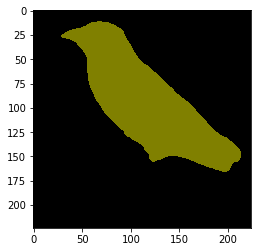

In [12]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [17]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

2019-12-02 03:02:23 URL:https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg [6604923/6604923] -> "horse.png" [1]


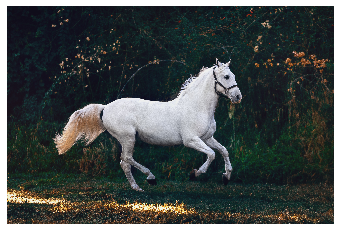

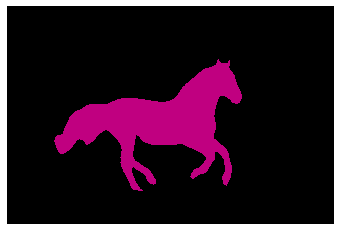

In [18]:
!wget -nv https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg -O horse.png
segment(fcn, './horse.png')

In [19]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/jeremytan/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100.0%


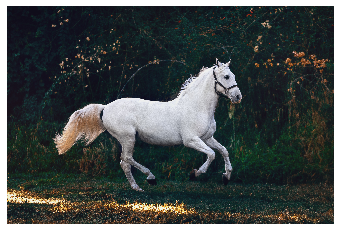

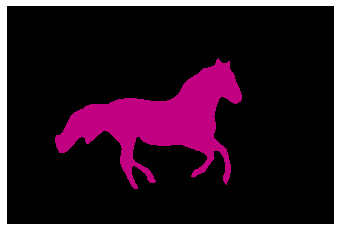

In [20]:
segment(dlab, './horse.png')

2019-12-02 03:04:59 URL:https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg [22870459/22870459] -> "person.png" [1]


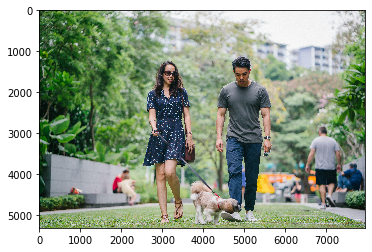

Segmenatation Image on FCN


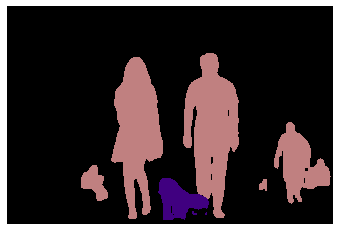

Segmenatation Image on DeepLabv3


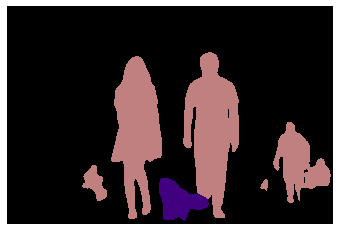

In [21]:
!wget -nv "https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg" -O person.png
img = Image.open('./person.png')
plt.imshow(img); plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path='./person.png', show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path='./person.png', show_orig=False)